# CYPLAN 255 Project

## Using Open-Source Bike Share Trip Data to Inform Social Distancing Street Closures

Due to the ongoing circumstances regarding COVID-19 Bay Area jurisdictions and state of California have mandated residents shelter-in-place. For those that go outside it is recommended that people follow social distancing guidelines that suggest people remain 6 feet away from each other to avoid further spread of the novel coronavirus. However, this can often be difficult in many built environments where the space allocated to vehicles dwarfs the width of the sidewalk.

<img src="../img/tingvall-201411.jpg" />

![](../img/tingval-201411.jpg)<div align="center">*Pedestrian road space, by Claes Tingvall of the Swedish Road Administration. [Source](https://ggwash.org/view/36573/to-a-pedestrian-a-roads-a-tiny-space-with-danger-just-beside)*.</div>

To encourage social distancing [many cities around the world](https://www.theguardian.com/world/2020/apr/11/world-cities-turn-their-streets-over-to-walkers-and-cyclists) have converted road space from automotive traffic to pedestrians and bicyclists. Although many of these are just temporary closures, the increased space for non-vehicular travel is allowing residents to get exercise, fresh air, and access still-open essential buildings in a more sustainable way.

Oakland has been receptive to these needs and recently [identified 74 miles of streets](https://sf.streetsblog.org/2020/04/10/oakland-to-open-74-miles-of-streets-for-safe-biking-and-recreation/) to be cordoned off for non-automotive travel. Not all cities in the Bay Area are following suit though. Despite the decrease in vehicular travel and the need for increased sidewalk space [San Francisco has not closed streets](https://sf.streetsblog.org/2020/03/30/people-desperate-for-space-but-so-far-bay-area-officials-wont-open-streets/) and a [letter](https://docs.google.com/document/u/1/d/e/2PACX-1vQQkbtEb3s0bfUMcLUMeu1Oa4OWnmxK9hsRLIRfw3PznZYCsc7kpUZ9pjpHS1La9PWUswL7q9LGVG7q/pub) and [petition](https://docs.google.com/forms/d/e/1FAIpQLSdIXHpAjaZVu9hTSbRgx7z5YAtl3ZiNsJTw3WA3-awvywsd9w/viewform) to repurpose Berkeley’s bicycle boulevards has yet to gain traction.

This project builds on the need for additional street closures to create safe streets in the Bay Area during the pandemic. I use open-source bike share data from BayWheels to identify the most frequented biking paths by system users. Together with maps of existing and planned bicycle facilities these routes can serve as recommendations for jurisdictions in the Bay Area that are looking to close streets to vehicular traffic to promote social distancing.

### `0_Process_BayWheels_Trips`

**Datasets used:**
* [System data](https://www.lyft.com/bikes/bay-wheels/system-data) from Bay Wheels. We process only trips from February 2020 because it is the latest dataset available (most current station layout and trip flows).
* [Regional bicycle facilities](http://opendata.mtc.ca.gov/datasets/regional-bike-facilities?geometry=-122.400%2C37.800%2C-122.144%2C37.847) in the Bay Area. From the Metropolitan Transportation Commission.
* [Census boundaries](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html) for California, including polygons for the state outline, census-designated places, and tracts.

**Notebook summary:**
* 0.0 - Import packages
* 0.1 - Import data
* 0.2 - Clean up the origin-destination trip pairs
* 0.3 - Identify unique stations in the dataset
    * Create geospatial dataframe with lat,lon of stations
* 0.4 - Label stations by region
    * Create geospatial dataframe with bounding boxes for each region
* 0.5 - Use OSMnx to get routes between each origin-destination trip pair
    * Load bicycle route networks from OpenStreetMap API using OSMnx
    * Convert station lat,lon coordinates into OSM nodes
    * Use OSM nodes to query shortest path routes using NetworkX
    * Update trips dataframe with routes
* 0.6 - Expand trips datafram
* 0.7 - Save data to file

**Additional reading:**
* "As New Yorkers seek open space, city will cut short car-free streets pilot" from [curbed.com](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* "How to open streets right during social distancing" from [streetsblog.org](https://usa.streetsblog.org/2020/04/08/how-to-open-streets-right-during-social-distancing)
* "NYC car-free streets pilot cut short" from [curbed.com](https://ny.curbed.com/2020/4/6/21209462/nyc-car-free-streets-coronavirus-bill-de-blasio)
* [This](https://twitter.com/jen_keesmaat/status/1248972266156720131) and other tweets by former Toronto Chief Planner Jennifer Keesmaat [@jen_keesmaat](https://twitter.com/jen_keesmaat)

## 0.0 Initialize notebook

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

## 0.1 Load data

In [19]:
# load raw trip data
trips = pd.read_csv("../data/202002-baywheels-tripdata.csv", low_memory=False)

In [20]:
# load census boundaries
outlines = gpd.read_file("zip://../data/cb_2016_us_state_500k.zip")
outlines = outlines.loc[outlines.GEOID=="06"]

## 0.2 Clean up the OD trip table

Lets fist take a look at the data and remove it of any illogical trips.

In [21]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432354 entries, 0 to 432353
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             432354 non-null  int64  
 1   start_time               432354 non-null  object 
 2   end_time                 432354 non-null  object 
 3   start_station_id         161723 non-null  float64
 4   start_station_name       161723 non-null  object 
 5   start_station_latitude   432354 non-null  float64
 6   start_station_longitude  432354 non-null  float64
 7   end_station_id           162194 non-null  float64
 8   end_station_name         162194 non-null  object 
 9   end_station_latitude     432354 non-null  float64
 10  end_station_longitude    432354 non-null  float64
 11  bike_id                  432354 non-null  int64  
 12  user_type                432354 non-null  object 
 13  rental_access_method     317843 non-null  object 
dtypes: f

In [22]:
trips.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,62083,2020-02-29 18:32:30.5750,2020-03-01 11:47:14.0850,176.0,MacArthur BART Station,37.828410,-122.266315,267.0,Derby St at College Ave,37.861804,-122.253569,1993,Customer,NaN
1,1364,2020-02-29 23:53:53.7190,2020-03-01 00:16:37.9720,375.0,Grove St at Masonic Ave,37.774836,-122.446546,506.0,7th Ave at Clement St,37.782439,-122.465377,12402,Customer,NaN
2,836,2020-02-29 23:54:03.1970,2020-03-01 00:07:59.8490,375.0,Grove St at Masonic Ave,37.774836,-122.446546,454.0,7th Ave at Cabrillo St,37.775176,-122.465007,2302,Customer,NaN
3,1004,2020-02-29 23:48:34.6480,2020-03-01 00:05:19.2020,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,200.0,2nd Ave at E 18th St,37.800214,-122.253810,902,Customer,NaN
4,1007,2020-02-29 23:48:25.9000,2020-03-01 00:05:13.4490,179.0,Telegraph Ave at 27th St,37.816073,-122.267886,200.0,2nd Ave at E 18th St,37.800214,-122.253810,11578,Customer,NaN


Illogical trips are routes that take too long or start and end in the same location. Although many bike share riders may take roundtrips, whether for leisure or for errands that require returning to the point of origin, these routes cannot be processed later and can be dropped from the dataset. This dataset is saved so this processing does not need to be done in later notebooks.

In [23]:
# Get reasonable upper bound of trips
trips.duration_sec.quantile(0.99)

3922.0

In [24]:
# So 99% of trips are under one hour. Let's drop all trips that are longer 
# from the dataset because they are likely circuitious or erroneous.
trips = trips.loc[trips.duration_sec <= trips.duration_sec.quantile(0.99)]

# Drop all trips that start and end in the same location.
trips = trips.loc[trips.start_station_id != trips.end_station_id]

Now that we have a cleaner dataframe we can group by origin-destination pair. This is not a necessary step but because this dataset is so large it will help to compress it here by dropping extraneous columns and grouping trips by their start and end locations. Below the data is grouped by start and end id, with the coordinates preserved.

In [25]:
# Group trips by Origin-Destination pair
trips = trips.groupby(["start_station_id", "end_station_id"]).agg({'start_time':'count',
                                                                   'start_station_name': 'first',
                                                                   'start_station_latitude': 'first',
                                                                   'start_station_longitude': 'first',
                                                                   'end_station_name': 'first',
                                                                   'end_station_latitude': 'first',
                                                                   'end_station_longitude': 'first'})
# Reset index and rename column with count data
trips.reset_index(inplace=True)
trips.rename(columns={"start_time": "count"}, inplace=True)

# Display aggregated dataframe
trips.head()

,start_station_id,end_station_id,count,start_station_name,start_station_latitude,start_station_longitude,end_station_name,end_station_latitude,end_station_longitude
0,3.0,4.0,5,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,Cyril Magnin St at Ellis St,37.785881,-122.408915
1,3.0,5.0,25,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,Powell St BART Station (Market St at 5th St),37.783899,-122.408445
2,3.0,6.0,9,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,The Embarcadero at Sansome St,37.804770,-122.403234
3,3.0,8.0,4,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,The Embarcadero at Vallejo St,37.799953,-122.398525
4,3.0,9.0,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,Broadway at Battery St,37.798572,-122.400869


## 0.3 Get unique stations from trip table

In order to map this data I need to create a geodataframe from the dataframe. To do this the data does not need to be in origin-destination format, but rather a dataframe of unique stations.

Below the trips are sorted by start and end id, then joined together to get a long form of the trips table. The `.dropna` and `.drop_duplicates` methods are applied to remove duplicates from the dataset.

Lastly, the shortened dataframe is converted into a geodataframe by assigning the `lat` and `lon` fields as the geometry.

In [10]:
# subset data for only origins and relevant columns
trips_start = trips[['start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude']]
trips_start.columns = ['station_id', 'name', 'lat', 'lon']

# subset data for only destinations and relevant columns
trips_end = trips[['end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude']]
trips_end.columns = ['station_id', 'name', 'lat', 'lon']

# drop extra columns from main trips dataframe now that they are no longer needed
trips = trips[['start_station_id','end_station_id','count']].copy()

# join origins and destinations, filter to only include unique/non-null values
stations = trips_start.append(trips_end)
stations.dropna(inplace=True)
stations.drop_duplicates(inplace=True)

# turn data into geospatial dataframe
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))

# view gdf
stations.head()

,station_id,name,lat,lon,geometry
0,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,POINT (-122.40490 37.78638)
155,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,POINT (-122.40892 37.78588)
241,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,POINT (-122.40844 37.78390)
391,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,POINT (-122.40323 37.80477)
466,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,POINT (-122.27174 37.80456)


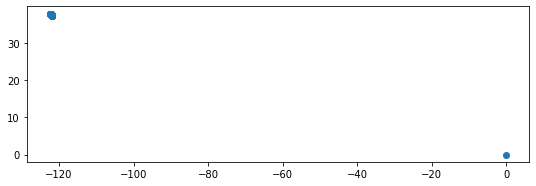

In [11]:
# plot gdf
stations.plot(figsize=(9,9))

Ok, so we did not drop all erroneous locations. It appears that some stations have coordinates at (0,0) which is definitely not in the Bay Area. They are manually dropped them from the geodataframe below.

In [12]:
stations.loc[(stations.lat==0) | (stations.lon==0)]

,station_id,name,lat,lon,geometry
3666,449.0,16th Depot Bike Fleet Station,0.0,0.0,POINT (0.00000 0.00000)


So the 16th Street bike fleet depot is not actually registered as a real station in their system. We can remove this station and all trips to it from our data.

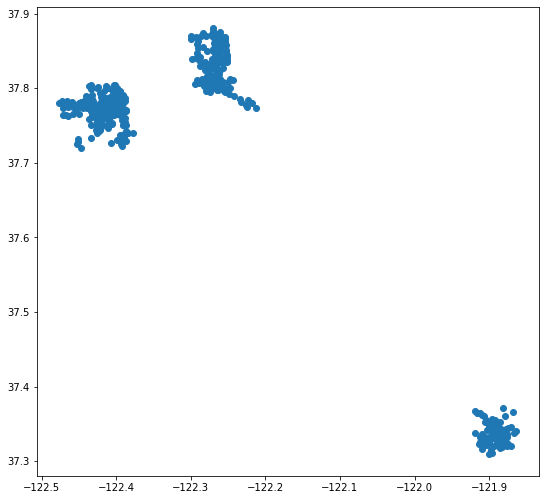

In [13]:
# clean trips dataframe
trips = trips.loc[(trips.start_station_id!=449.0) | (trips.end_station_id!=449.0)]

# clean stations geodataframe
stations = stations.loc[(stations.lat!=0) | (stations.lon!=0)]

# plot stations
stations.plot(figsize=(9,9))

## 0.4 Label stations by regions 

As seen in the plot above there are three distinct regions of stations. Bay Wheels operates in San Francisco, San Jose, and the East Bay (Berkeley, Emeryville, and Oakland). Although it is possible to move a bike between these regions it is highly impractical (Oakland --> San Jose is a 4 hour ride) or requires additional modes of travel (Oakland --> San Francisco would require taking the bus or train because there is no bike path over entire the Bay Bridge).

Self-defined bounding boxes are created below to label trips as being in specific regions and remove trips between regions. Defining the regions will also allow for easier visualizations and analysis later by selecting on stations by region.

In [14]:
# import shapely package to create bounding boxes
from shapely.geometry import Polygon

In [15]:
# Define a bounding boxes for bike share regions. The coordinates were manually identified.
regions = [{"name": "East Bay", "lat": [37.9, 37.9, 37.76, 37.76, 37.9], 
                                "lon": [-122.2, -122.32, -122.32, -122.2, -122.2]},
           {"name": "San Francisco", "lat": [37.81, 37.81, 37.71, 37.71, 37.81], 
                                     "lon": [-122.37, -122.48, -122.48, -122.37, -122.37]},
           {"name": "San Jose", "lat": [37.375, 37.375, 37.305, 37.305, 37.375], 
                                "lon": [-121.86, -121.925, -121.925, -121.86, -121.86]}]

# Create empty gdf to store data. The coordinate reference system is defined as WGS84 so the 
# coordinates are properly located on the map.
crs = 'epsg:4326'
bbox_gdf = gpd.GeoDataFrame(columns=["region", "geometry"], crs=crs)

# Loop through regions, create bounding boxes for each one
for i in range(len(regions)):
    polygon_geom = Polygon(zip(regions[i]['lon'], regions[i]['lat']))
    bbox_gdf = bbox_gdf.append({'region': regions[i]['name'], 'geometry': polygon_geom}, ignore_index=True)

In [16]:
# Save bounding box gdf to file
bbox_gdf.to_file(driver='GeoJSON', filename="../data/baywheels_regions_bbox.geojson")

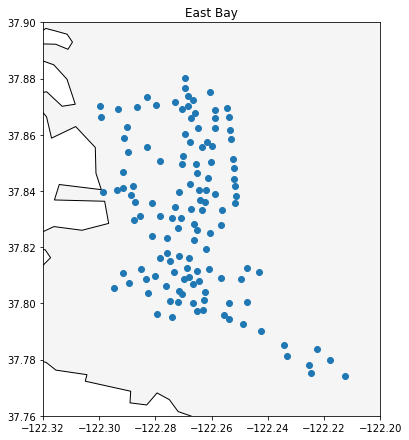

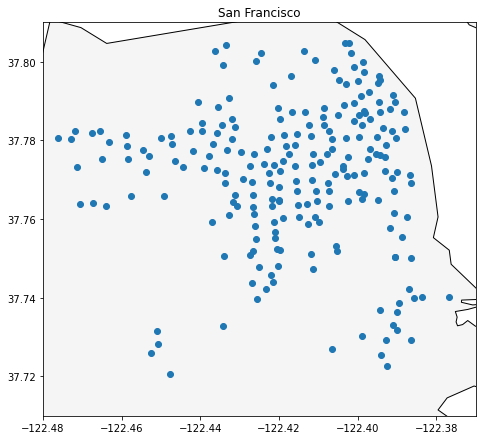

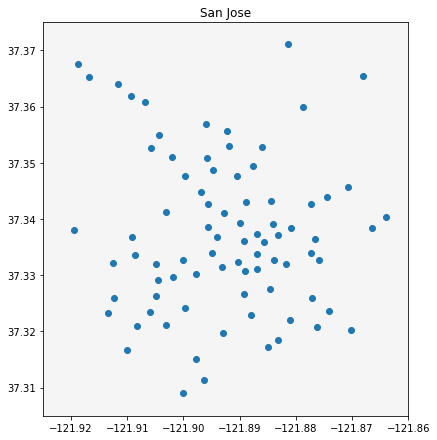

In [17]:
# Plot all three regions
for index, row in bbox_gdf.iterrows():
    # Create figure
    fig, ax = plt.subplots(figsize = (9,6))
    
    # Plot outline of CA
    outlines.plot(ax=ax, color='whitesmoke', edgecolor='black')
    
    # Plot stations within bounding box
    geom = bbox_gdf.loc[index, 'geometry']
    stations.loc[stations.within(geom)].plot(ax=ax)

    # Add plot descriptions, set bounds, and display 
    plt.tight_layout()
    plt.title(row['region'])
    ax.set_xlim((geom.bounds[0], geom.bounds[2]))
    ax.set_ylim((geom.bounds[1], geom.bounds[3]))
    plt.show()

## 0.5 OSMnx

Now that I have stations and their regions it is time to generate routes for each one. This section requires [OSMnx](https://github.com/gboeing/osmnx), a Python package that allows for analysis of OpenStreetMaps' network. First, the package is loaded into memory.

https://stackoverflow.com/questions/13331698/how-to-apply-a-function-to-two-columns-of-pandas-dataframe
https://stackoverflow.com/questions/37428218/how-to-properly-apply-a-lambda-function-into-a-pandas-data-frame-column

In [17]:
# import OSMnx methods
import osmnx as ox
import networkx as nx
%matplotlib inline
ox.config(log_console=True, use_cache=True)
ox.__version__

'0.11.4'

In [18]:
# import timing methods
import time
from tqdm import tqdm

Now that OSMnx is imported I need to retrieve the street network for the Bay Wheels regions. This step could be done all at once, but the processing time and memory required to load that large a street network is unnecessary. Instead, the bounding boxes from the regions created above are used to create OSMnx networks.

Below we loop through each region, retrieve the street network, then collect the node ids (unique IDs for points in the OpenStreetMap network) for each Bay Wheels station.

Sources referenced to create this section:
* https://stackoverflow.com/questions/58257528/osmnx-shortest-path-for-a-set-of-origins-and-destinations
* https://stackoverflow.com/questions/46238813/osmnx-get-coordinates-of-nodes-using-osm-id

In [19]:
# create empty dataframe and list to store outputs
nodes_df = pd.DataFrame(columns=['station_id', 'ox_node', 'region'])
networks = []

# Loop through each region in bbox_gdf
for index, row in bbox_gdf.iterrows():
    
    # Create variables for region (r) and the index (i)
    r = row['region']
    i = index
    
    print(f"Retrieving OSMnx network within {r}")
    
    # Define a bounding box for the current region
    bounds = bbox_gdf.loc[bbox_gdf.region==r].geometry.bounds
    north, south, east, west = bounds.maxy[i], bounds.miny[i], bounds.maxx[i], bounds.minx[i]
    
    # Create network from that bounding box. Setting network_type='bike' because 
    # we want on- and off-road bike paths. Save this network to the networks list so it can be
    # accessed later.
    G = ox.graph_from_bbox(north, south, east, west, network_type='bike')
    networks.append(G)
    
    print(f"Collecting OSMnx node ids within {r}")
    
    # Create empty array to store nodes
    nodes_list = []
    station_ids = []
    region_name = []
    
    # Select all nodes in that region
    temp_gdf = stations.loc[stations.within(bbox_gdf.loc[i, 'geometry'])].copy()

    # Loop though all stations in the current region. Get the nearest node and save
    # that id to an array.
    for j in tqdm(range(len(temp_gdf))):
        node = ox.get_nearest_node(G, (temp_gdf.iloc[j]['lat'], temp_gdf.iloc[j]['lon']))
        nodes_list.append(node)
        station_ids.append(temp_gdf.iloc[j]['station_id'])
        region_name.append(r)

    # Create dataframe with the nodes in the current region, then append to a dataframe with
    # nodes from all stations in all regions.
    temp_df = pd.DataFrame({'station_id': station_ids,
                            'ox_node': nodes_list,
                            'region': region_name}) 
    nodes_df = nodes_df.append(temp_df)

Retrieving OSMnx network within East Bay


  2%|█▎                                                                                | 2/128 [00:00<00:10, 11.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [00:20<00:00,  6.24it/s]


Retrieving OSMnx network within San Francisco


  1%|▋                                                                                 | 2/224 [00:00<00:17, 12.42it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 224/224 [00:25<00:00,  8.79it/s]


Retrieving OSMnx network within San Jose


  2%|██                                                                                 | 2/82 [00:00<00:04, 19.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 82/82 [00:05<00:00, 14.69it/s]


In [20]:
# Merge nearest nodes df with stations gdf
stations = stations.merge(nodes_df, on="station_id", how="left")

# Display new gdf
stations.head()

,station_id,name,lat,lon,geometry,ox_node,region
0,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,POINT (-122.40490 37.78638),6489941287,San Francisco
1,4.0,Cyril Magnin St at Ellis St,37.785881,-122.408915,POINT (-122.40892 37.78588),65313138,San Francisco
2,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,POINT (-122.40844 37.78390),1723739163,San Francisco
3,6.0,The Embarcadero at Sansome St,37.804770,-122.403234,POINT (-122.40323 37.80477),33241803,San Francisco
4,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,POINT (-122.27174 37.80456),3244767454,East Bay


In [21]:
# Checking how many stations were identified by OSMnx. If these numbers don't 
# add up return to the loop two cells above and check for errors.
print(f"All stations: {len(stations)}")
print(f"Stations in the East Bay: {len(stations[stations.region=='East Bay'].ox_node)}")
print(f"Stations in San Francisco: {len(stations[stations.region=='San Francisco'].ox_node)}")
print(f"Stations in San Jose: {len(stations[stations.region=='San Jose'].ox_node)}")

All stations: 436
Stations in the East Bay: 128
Stations in San Francisco: 226
Stations in San Jose: 82


Now that we have nodes and regions attached to the stations we want to also attach it to the trips. We have station ids and coordinates for each trip but not OSM nodes that are necessary for routing.

In [22]:
# Add start station ox_node and region to trips df
trips = trips.merge(stations[['station_id', 'ox_node', 'region']], 
                    left_on="start_station_id", 
                    right_on="station_id",
                    how="left")
trips.drop(columns=['station_id'], inplace=True)
trips.rename(columns={'ox_node': 'start_node', 'region': 'start_region'}, inplace=True)

# Add end station ox_node and region to trips df
trips = trips.merge(stations[['station_id', 'ox_node', 'region']], 
                    left_on="end_station_id", 
                    right_on="station_id")
trips.drop(columns=['station_id'], inplace=True)
trips.rename(columns={'ox_node': 'end_node', 'region': 'end_region'}, inplace=True)

# Display updated trips df
trips.head()

,start_station_id,end_station_id,count,start_node,start_region,end_node,end_region
0,3.0,4.0,5,6489941287,San Francisco,65313138,San Francisco
1,5.0,4.0,2,1723739163,San Francisco,65313138,San Francisco
2,6.0,4.0,2,33241803,San Francisco,65313138,San Francisco
3,10.0,4.0,1,65374771,San Francisco,65313138,San Francisco
4,11.0,4.0,3,65328969,San Francisco,65313138,San Francisco


In [23]:
# Drop all trips that don't start and end in the same region. As mentioned above this could happen only if
# the bike rider took the bike on transit or in a car to another region...even if they did manage
# to bike from Oakland to San Jose it is not useful for this analysis.
trips = trips.loc[trips.start_region==trips.end_region].copy()

# With those trips dropped the 'start_region' and 'end_region' columns are identical, can
# drop one to save memory.
trips.drop(columns=['start_region'], inplace=True)
trips.rename(columns={'end_region': 'region'}, inplace=True)

In the loop above the networks queried using OSMnx were saved to a list. We want to be able to use these later for routing, analysis, and visualization so they are assigned to variables below.

    G0 = East Bay network
    G1 = San Francisco network
    G2 = San Jose network

In [24]:
# Create variables for each network
G0, G1, G2 = [x for x in networks]

# Delete list of networks (and network created in loop above) to save memory
del networks
del G

# The networks could also be combined into one variable using the code below. This has not been
# a necessary step so far, so it has been commented out.
# G = nx.compose(G0, G1)
# G = nx.compose(G, G2)
# fig, ax = ox.plot_graph(G)

In addition to preserving the networks it is useful to save the networks as geodataframes of nodes and edges. They will be needed in the next step for routing and also useful to save so the data does not have to be re-processed.

Some code used below from: https://automating-gis-processes.github.io/2017/lessons/L7/network-analysis.html

In [25]:
# Convert networking nodes and edges to geodataframes
g0_nodes, g0_edges = ox.graph_to_gdfs(G0)
g1_nodes, g1_edges = ox.graph_to_gdfs(G1)
g2_nodes, g2_edges = ox.graph_to_gdfs(G2)

# Save nodes to file.
g0_nodes.to_file(driver='GeoJSON', filename="../data/G0_nodes.geojson")
g1_nodes.to_file(driver='GeoJSON', filename="../data/G1_nodes.geojson")
g2_nodes.to_file(driver='GeoJSON', filename="../data/G2_nodes.geojson")

# Edges commented out because they were not saving properly. Additionally, they are not needed later
# because the maps created will contain the routes generated using NetworkX below.
# g0_edges.to_file(driver='GeoJSON', filename="../data/G0_edges.geojson")
# g1_edges.to_file(driver='GeoJSON', filename="../data/G1_edges.geojson")
# g2_edges.to_file(driver='GeoJSON', filename="../data/G2_edges.geojson")
del g0_edges, g1_edges, g2_edges

The last step is to use the `.shortest_path` method from NetworkX to generate routes for each unique trip between bike share stations. The code for this step can be found in cells 12, 13, and 14 in [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/06-example-osmnx-networkx.ipynb). In short, the cells below loop through each trip and use the `start_node` and the `end_node` to get a route between the two. Shortest path routes are used because most often trips are taken that optimize the path from A to B. Because we deleted all circuitious trips (A to A, B to B, etc.) we assume there are no leisure trips taken so the best path between the origin and destination is selected. Then, using the geodataframes of nodes created above the routes (which are returned as arrays of nodes between the origin and destination) are converted into a list of points. These are then converted into Shapely Linestrings and can be used as geometry features to append to the trips and create a geodataframe with the routes for each trip.

The networks (`G0`, `G1`, and `G2`) are saved in memory so no external API is required to generate these paths. This process is still very expensive (computationally) though so it will take a couple minutes to process.

In [26]:
# Import LineString and Point shapes from Shapely package
from shapely.geometry import LineString, Point

In [28]:
# create empty arrays to store data
paths = []
lines = []

# Loop through each trip in the trips df
for i in tqdm(range(len(trips))):
    
    # create variables for the current origin, destination, and region
    origin_node = trips.iloc[i]['start_node']
    destination_node = trips.iloc[i]['end_node']
    region = trips.iloc[i]['region']
    
    # Using the network for each region, generate the shortest path and 
    # convert this to a Shapely LineString so it can be analyzed and mapped
    # with geopandas and not just parsed by OSMnx.
    if region == "East Bay":
        route = nx.shortest_path(G0, origin_node, destination_node)
        route_nodes = g0_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Francisco":
        route = nx.shortest_path(G1, origin_node, destination_node)
        route_nodes = g1_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    elif region == "San Jose":
        route = nx.shortest_path(G2, origin_node, destination_node)
        route_nodes = g2_nodes.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))
    else:
        route = np.nan
        route_line = np.nan
        
    # Append route and route_line to arrays outside of the loop
    paths.append(route)
    lines.append(route_line)

100%|████████████████████████████████████████████████████████████████████████████| 23924/23924 [06:31<00:00, 61.05it/s]


In [29]:
# Add route paths (arrays of OSM nodes along the route) to the trips dataframe
trips['route'] = np.array(paths)

In [30]:
# Create geodataframe with trips where geometry is a linestring of the shortest path route
# between start_station_id and end_station_id.
trips_gdf = gpd.GeoDataFrame(trips, crs=crs, geometry=lines)

# Display new geodataframe with routes
trips_gdf.head()

,start_station_id,end_station_id,count,start_node,end_node,region,route,geometry
0,3.0,4.0,5,6489941287,65313138,San Francisco,"[6489941287, 5858516688, 1723738887, 721705712...","LINESTRING (-122.40508 37.78638, -122.40523 37..."
1,5.0,4.0,2,1723739163,65313138,San Francisco,"[1723739163, 65313131, 65313133, 65313138]","LINESTRING (-122.40807 37.78401, -122.40853 37..."
2,6.0,4.0,2,33241803,65313138,San Francisco,"[33241803, 260194262, 280836272, 6250503702, 2...","LINESTRING (-122.40345 37.80504, -122.40228 37..."
3,10.0,4.0,1,65374771,65313138,San Francisco,"[65374771, 4039511684, 65337586, 65336155, 653...","LINESTRING (-122.40497 37.79533, -122.40565 37..."
4,11.0,4.0,3,65328969,65313138,San Francisco,"[65328969, 65372268, 65336941, 65307352, 65307...","LINESTRING (-122.39835 37.79709, -122.39819 37..."


## 0.6 Expand trips_gdf to have unique row for each count

To remove unecessary loops the trips dataframe was grouped earlier in the notebook to consolidate multiple trips. However, for later analysis we need to [expand](https://stackoverflow.com/questions/50257516/expand-pandas-dataframe-by-values-in-column) trips_gdf to have a row for each value in the column count. So, if there are 5 trips from station 3 to station 4 then this code will create a dataframe with 5 rows of that same trip. This will be important later when we want to get locations with the greatest density of trips.

**NOTE:** This section was commented out because it was creating a very large file. This is not necessary at this stage because the data can always be expanded later.

In [ ]:
# print(f"Length of grouped trips_gdf: {len(trips_gdf)}")

# # Expand trips_gdf
# trips_gdf = trips_gdf.reindex(trips_gdf.index.repeat(trips_gdf['count']))

# # Create a column named position in the expanded dataframe to keep track of how many rows of data
# # there are per trip.
# trips_gdf['position'] = trips_gdf.groupby(level=0).cumcount()+1

# # Print length of new dataframe
# print(f"Length of expanded trips_gdf: {len(trips_gdf)}")

# # Display gdf to preview how this worked
# trips_gdf.head(10)

## 0.7 Save geodataframe of trips and stations to file

Preserving the data to file will allow for access later without having to run this notebook.

In [32]:
# Save geodataframe of trip routes to file. 
# The column 'route' has to be deleted because .geojson files do not allow columns with type list.
trips_gdf.drop(columns=['route']).to_file(driver='GeoJSON', filename="../data/baywheels_routes_osmnx.geojson")

In [33]:
# Save geodataframe of stations to file. 
stations.to_file(driver='GeoJSON', filename="../data/baywheels_stations.geojson")